# Minimum, Maximum, and Mixture

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.6.8-py3-none-any.whl size=12122 sha256=fcac37f82d30d870fc11d515964bf6aeef75f8e2e4993b796f45d9805bd152ca
  Stored in directory: /root/.cache/pip/wheels/c2/2f/73/700abc644ee5aba92a8b40552794103c445cd47fcdfe7828f7
Successfully built empiricaldist


In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

Downloaded utils.py


In [3]:
from utils import set_pyplot_params
set_pyplot_params()

In the previous chapter we computed distributions of sums.
In this chapter, we'll compute distributions of minimums and maximums, and use them to solve both forward and inverse problems.

Then we'll look at distributions that are mixtures of other distributions, which will turn out to be particularly useful for making predictions.

But we'll start with a powerful tool for working with distributions, the cumulative distribution function.

## Cumulative Distribution Functions

So far we have been using probability mass functions to represent distributions.
A useful alternative is the **cumulative distribution function**, or CDF.

As an example, I'll use the posterior distribution from the Euro problem, which we computed in <<_BayesianEstimation>>.

Here's the uniform prior we started with.

In [4]:
import numpy as np
from empiricaldist import Pmf

hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250

And here's the update.

In [5]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """이항분포를 사용한 pmf 갱신"""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [6]:
update_binomial(pmf, data)

The CDF is the cumulative sum of the PMF, so we can compute it like this:

In [7]:
cumulative = pmf.cumsum()

Here's what it looks like, along with the PMF.

In [8]:
from utils import decorate

def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

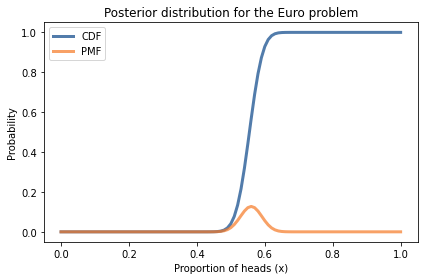

In [9]:
cumulative.plot(label='CDF')
pmf.plot(label='PMF')
decorate_euro(title='Posterior distribution for the Euro problem')

The range of the CDF is always from 0 to 1, in contrast with the PMF, where the maximum can be any probability.

The result from `cumsum` is a Pandas `Series`, so we can use the bracket operator to select an element:

In [10]:
cumulative[0.61]

0.9638303193984255

결과는 0.96으로, 이는 0.61과 같거나 이보다 작은 값에 대한 총 확률이 96%라는 뜻이다.

To go the other way --- to look up a probability and get the corresponding quantile --- we can use interpolation:

In [11]:
from scipy.interpolate import interp1d

ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps, qs)
interp(0.96)

array(0.60890171)

결과는 약 0.61이므로, 이 분포의 96분위에 해당하는 값이 0.61임을 알 수 있다.

`empiricaldist` provides a class called `Cdf` that represents a cumulative distribution function.
Given a `Pmf`, you can compute a `Cdf` like this:

In [12]:
cdf = pmf.make_cdf()

`make_cdf` uses `np.cumsum` to compute the cumulative sum of the probabilities.

You can use brackets to select an element from a `Cdf`:

In [13]:
cdf[0.61]

0.9638303193984255

But if you look up a quantity that's not in the distribution, you get a `KeyError`.


In [14]:
try:
    cdf[0.615]
except KeyError as e:
    print(repr(e))

KeyError(0.615)


To avoid this problem, you can call a `Cdf` as a function, using parentheses.
If the argument does not appear in the `Cdf`, it interpolates between quantities.

In [15]:
cdf(0.615)

array(0.96383032)

Going the other way, you can use `quantile` to look up a cumulative probability and get the corresponding quantity:


In [16]:
cdf.quantile(0.9638303)

array(0.61)

`Cdf` also provides `credible_interval`, which computes a credible interval that contains the given probability:


In [17]:
cdf.credible_interval(0.9)

array([0.51, 0.61])

CDFs and PMFs are equivalent in the sense that they contain the
same information about the distribution, and you can always convert
from one to the other.
Given a `Cdf`, you can get the equivalent `Pmf` like this:

In [18]:
pmf = cdf.make_pmf()

`make_pmf` uses `np.diff` to compute differences between consecutive cumulative probabilities.

One reason `Cdf` objects are useful is that they compute quantiles efficiently.
Another is that they make it easy to compute the distribution of a maximum or minimum, as we'll see in the next section.

## Best Three of Four

In *Dungeons & Dragons*, each character has six attributes: strength, intelligence, wisdom, dexterity, constitution, and charisma.

새로운 캐릭터를 만들 때는, 플레이어는 각 능력치에 대해 육면체 주사위 4개를 굴린 후 이 중 세 개의 높은 값을 더한다. 예를 들어, 내가 근력을 얻고자 주사위 4개를 굴려서 1, 2, 3, 4가 나왔다면, 내 캐릭터의 근력은 제일 낮은 값 1을 제외한 2, 3, 4의 합인 9이다.

As an exercise, let's figure out the distribution of these attributes.
Then, for each character, we'll figure out the distribution of their best attribute.

I'll import two functions from the previous chapter: `make_die`, which makes a `Pmf` that represents the outcome of rolling a die, and `add_dist_seq`, which takes a sequence of `Pmf` objects and computes the distribution of their sum.

Here's a `Pmf` that represents a six-sided die and a sequence with three references to it.

In [19]:
from utils import make_die

die = make_die(6)
dice = [die] * 3

In [20]:
dice

[1    0.166667
 2    0.166667
 3    0.166667
 4    0.166667
 5    0.166667
 6    0.166667
 Name: , dtype: float64, 1    0.166667
 2    0.166667
 3    0.166667
 4    0.166667
 5    0.166667
 6    0.166667
 Name: , dtype: float64, 1    0.166667
 2    0.166667
 3    0.166667
 4    0.166667
 5    0.166667
 6    0.166667
 Name: , dtype: float64]

세 주사위 결과값의 합의 분포

In [21]:
from utils import add_dist_seq

pmf_3d6 = add_dist_seq(dice)

Here's what it looks like:

In [22]:
def decorate_dice(title=''):
    decorate(xlabel='Outcome',
             ylabel='PMF',
             title=title)

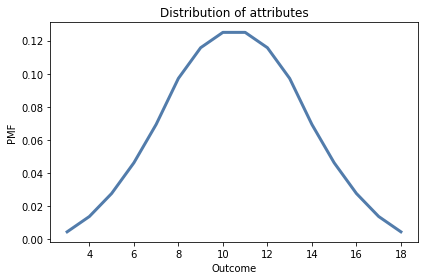

In [23]:
pmf_3d6.plot()
decorate_dice('Distribution of attributes')

If we roll four dice and add up the best three, computing the distribution of the sum is a bit more complicated.
I'll estimate the distribution by simulating 10,000 rolls.

First I'll create an array of random values from 1 to 6, with 10,000 rows and 4 columns:

In [24]:
n = 10000
a = np.random.randint(1, 7, size=(n, 4))

각 행에서 세 개의 높은 값을 찾기 위해, `axis=1` 로 설정해서 새로 정렬하자. 이렇게 하면 각 행에서 낮은 값부터 큰 값으로 값이 정렬된다.der.

In [25]:
a.sort(axis=1)

끝의 세 열을 선택하고 이 값을 더한다.

In [26]:
t = a[:, 1:].sum(axis=1)

Now `t` is an array with a single column and 10,000 rows.
We can compute the PMF of the values in `t` like this:

In [27]:
pmf_best3 = Pmf.from_seq(t)

The following figure shows the distribution of the sum of three dice, `pmf_3d6`, and the distribution of the best three out of four, `pmf_best3`.

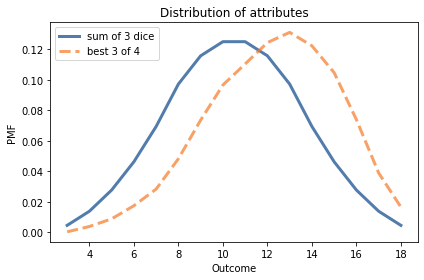

In [28]:
pmf_3d6.plot(label='sum of 3 dice')
pmf_best3.plot(label='best 3 of 4', ls='--')

decorate_dice('Distribution of attributes')

예상했겠지만, 넷 중 높은 값 셋을 고르는 것이 좀 더 높은 값을 내는 경향이 있다.

다음으로는 네 주사위 값 중 세 개를 더해서 만든 각 여섯 개의 능력치 중 최댓값의 분포를 찾아보자

## Maximum

To compute the distribution of a maximum or minimum, we can make good use of the cumulative distribution function.
First, I'll compute the `Cdf` of the best three of four distribution:

In [29]:
cdf_best3 = pmf_best3.make_cdf()

`Cdf(x)`는 `x`보다 같거나 작은 값에 대한 확률의 합임을 기억하자. 즉, 이 분포에서 임의로 고른 값이 `x`보다 같거나 작을 확률이다.

이 분포에서 6개의 값을 골랐다고 가정해보자. 모든 6개의 값이 `x`보다 같거나 작을 확률은 `Cdf(x)`를 6 제곱한 값으로, 다음과 같이 구할 수 있다.

In [30]:
cdf_best3**6

3     4.096000e-21
4     6.321363e-15
5     5.289853e-12
6     8.372020e-10
7     4.261131e-08
8     1.534708e-06
9     3.516183e-05
10    4.576324e-04
11    3.411853e-03
12    1.809901e-02
13    7.100539e-02
14    2.016936e-01
15    4.351236e-01
16    7.094730e-01
17    9.044430e-01
18    1.000000e+00
Name: , dtype: float64

If all 6 values are less than or equal to `x`, that means that their maximum is less than or equal to `x`.
So the result is the CDF of their maximum.
We can convert it to a `Cdf` object, like this:

In [31]:
from empiricaldist import Cdf

cdf_max6 = Cdf(cdf_best3**6)

And compute the equivalent `Pmf` like this:

In [32]:
pmf_max6 = cdf_max6.make_pmf()

The following figure shows the result.

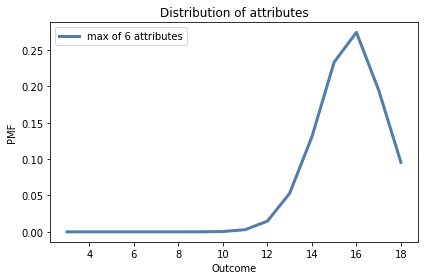

In [33]:
pmf_max6.plot(label='max of 6 attributes')

decorate_dice('Distribution of attributes')

Most characters have at least one attribute greater than 12; almost 10% of them have an 18.

The following figure shows the CDFs for the three distributions we have computed.

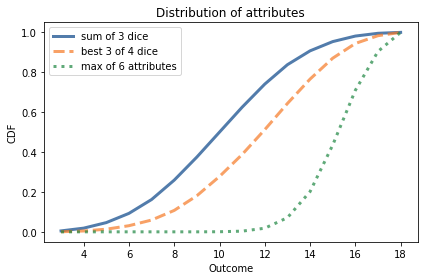

In [34]:
import matplotlib.pyplot as plt

cdf_3d6 = pmf_3d6.make_cdf()
cdf_3d6.plot(label='sum of 3 dice')

cdf_best3 = pmf_best3.make_cdf()
cdf_best3.plot(label='best 3 of 4 dice', ls='--')

cdf_max6.plot(label='max of 6 attributes', ls=':')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

`Cdf` provides `max_dist`, which does the same computation, so we can also compute the `Cdf` of the maximum like this:

In [35]:
cdf_max_dist6 = cdf_best3.max_dist(6)

And we can confirm that the differences are small.

In [36]:
np.allclose(cdf_max_dist6, cdf_max6)

True

In the next section we'll find the distribution of the minimum.
The process is similar, but a little more complicated.
See if you can figure it out before you go on.

## Minimum

In the previous section we computed the distribution of a character's best attribute.
최저 능력치 분포를 알아볼 차례이다.

To compute the distribution of the minimum, we'll use the **complementary CDF**, which we can compute like this:

In [37]:
prob_gt = 1 - cdf_best3

변수 이름에서 알 수 있듯 complementary CDF는 `x` 보다 큰 분포상의 값에 대한 확률이다. 모든 6개의 값이 `x`를 초과할 확률은 다음과 같다.

In [38]:
prob_gt6 = prob_gt**6

만약 6개 속성값 모두가 `x`를 초과한다면, 최솟값 역시 `x`를 초과하므로 `prob_gt6`은 최소값의 complementary CDF가 된다.즉, 다음과 같이 최소값의 CDF를 구할 수 있다.

In [39]:
prob_le6 = 1 - prob_gt6

The result is a Pandas `Series` that represents the CDF of the minimum of six attributes.  We can put those values in a `Cdf` object like this:

In [40]:
cdf_min6 = Cdf(prob_le6)

Here's what it looks like, along with the distribution of the maximum.

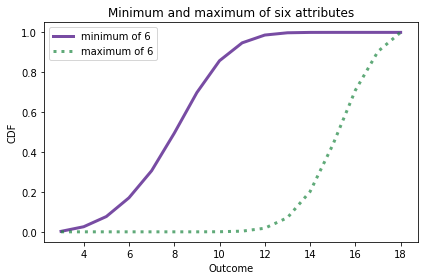

In [41]:
cdf_min6.plot(color='C4', label='minimum of 6')
cdf_max6.plot(color='C2', label='maximum of 6', ls=':')
decorate_dice('Minimum and maximum of six attributes')
plt.ylabel('CDF');

`Cdf` provides `min_dist`, which does the same computation, so we can also compute the `Cdf` of the minimum like this:

In [42]:
cdf_min_dist6 = cdf_best3.min_dist(6)

And we can confirm that the differences are small.

In [43]:
np.allclose(cdf_min_dist6, cdf_min6)

True

In the exercises at the end of this chapter, you'll use distributions of the minimum and maximum to do Bayesian inference.
But first we'll see what happens when we mix distributions.

## Mixture

In this section I'll show how we can compute a distribution which is a mixture of other distributions.
I'll explain what that means with some simple examples;
then, more usefully, we'll see how these mixtures are used to make predictions.

Here's another example inspired by *Dungeons & Dragons*:

* 당신의 캐릭터가 한 손에는 단도로, 다른 손에는 단검으로 무장했다고 가정하자.

* 각 단계에서, 가지고 있는 두 개의 무기 중 임의로 하나를 골라 괴물을 공격한다.

* 단도는 사면체 주사위를 한 번 굴려서 나온 결과만큼의 피해를 주고, 단검은 육면체 주사위를 한 번 굴린 결과만큼의 피해를 준다.

이 때 각 단계에서 주게 되는 피해의 분포는 어떻게 될까?

이 질문에 답하기 위해, 사면체 주사위와 육면체 주사위를 나타내는 `Pmf`를 만들어보자.

In [44]:
d4 = make_die(4)
d6 = make_die(6)

Now, let's compute the probability you inflict 1 point of damage.

* 단도로 공격한 경우의 확률은 1/4이다.

* 단검으로 공격한 경우는 1/6이다.

각 무기를 고를 확률은 1/2이므로, 총 확률은 둘의 평균이다.

In [45]:
prob_1 = (d4(1) + d6(1)) / 2
prob_1

0.20833333333333331

2, 3, 4가 나올 확률 역시 이와 동일하지만, 5와 6의 경우는 다르다. 이 두 값은 사면체 주사위에서는 나올 수 없기 때문이다.

In [46]:
prob_6 = (d4(6) + d6(6)) / 2
prob_6

0.08333333333333333

이 혼합 분포를 구하려면, 가능한 결괏값에 대해 반복적으로 계산해서 확률을 구하면 된다. 하지만 여기서는 동일한 연산을 `+` 연산자를 사용한다.

In [47]:
mix1 = (d4 + d6) / 2

Here's what the mixture of these distributions looks like.

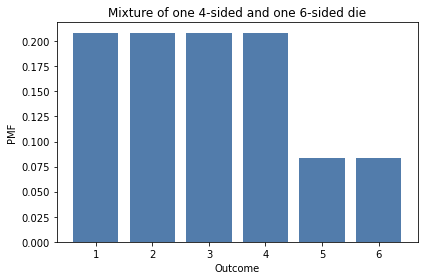

In [48]:
mix1.bar(alpha=0.7)
decorate_dice('Mixture of one 4-sided and one 6-sided die')

이제 세 마리의 괴물과 전투하고 있다고 가정하자.

* 한 마리는 곤봉을 들고 있고, 이는 사면체 주사위 하나의 결과에 따른 피해를 준다.
* 한 마리는 철퇴를 들고 있고, 이는 육면체 주사위 하나의 결과에 따른 피해를 준다.
* 나머지 한 마리는 육척봉을 들고 있고, 이 경우도 육면체 주사위 하나의 결과에 따른 피해를 준다.

매 회 이 몬스터 중 하나에게 공격당하게 된다. 이 몬스터들이 주는 피해의 분포를 찾기 위해 다음과 같이 이 분포에 대해 가중 평균을 구해보자.

In [49]:
mix2 = (d4 + 2*d6) / 3

This distribution is a mixture of one 4-sided die and two 6-sided dice.
Here's what it looks like.

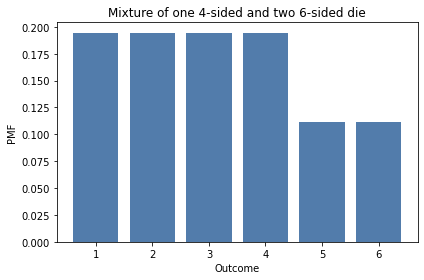

In [50]:
mix2.bar(alpha=0.7)
decorate_dice('Mixture of one 4-sided and two 6-sided die')

In this section we used the `+` operator, which adds the probabilities in the distributions, not to be confused with `Pmf.add_dist`, which computes the distribution of the sum of the distributions.

To demonstrate the difference, I'll use `Pmf.add_dist` to compute the distribution of the total damage done per round, which is the sum of the two mixtures:

In [51]:
total_damage = Pmf.add_dist(mix1, mix2)

And here's what it looks like.

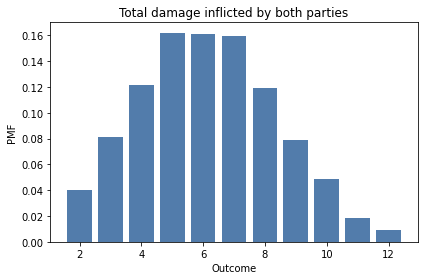

In [52]:
total_damage.bar(alpha=0.7)
decorate_dice('Total damage inflicted by both parties')

## General Mixtures

In the previous section we computed mixtures in an *ad hoc* way.
Now we'll see a more general solution.
In future chapters, we'll use this solution to generate predictions for real-world problems, not just role-playing games.
But if you'll bear with me, we'll continue the previous example for one more section.

세 마리의 괴물이 추가로 전투에 참여했다. 각 괴물을 팔면체 주사위를 한 번 굴린 결과만큼의 피해를 주는 전투용 도끼를 가지고 있다. 여전히 회당 임의로 선택된 한 마리의 괴물만 공격하므로, 이 때 몬스터에 의한 피해는 다음의 혼합이다.

* One 4-sided die,
* Two 6-sided dice, and
* Three 8-sided dice.

I'll use a `Pmf` to represent a randomly chosen monster:

In [53]:
hypos = [4,6,8]
counts = [1,2,3]
pmf_dice = Pmf(counts, hypos)
pmf_dice.normalize()
pmf_dice

,probs
4,0.166667
6,0.333333
8,0.500000


이 분포는 주사위 종류와 각 주사위를 굴릴 확률을 나타낸다. 예를 들어, 여섯 괴물 중 한 마리가 단도를 들고 있으므로, 사면체 주사위를 굴릴 확률은 1/6이다.

Next I'll make a sequence of `Pmf` objects to represent the dice:

In [54]:
dice = [make_die(sides) for sides in hypos]

To compute the distribution of the mixture, I'll compute the weighted average of the dice, using the probabilities in `pmf_dice` as the weights.

To express this computation concisely, it is convenient to put the distributions into a Pandas `DataFrame`:

In [55]:
import pandas as pd

pd.DataFrame(dice)

,1,2,3,4,5,6,7,8
,0.250000,0.250000,0.250000,0.250000,NaN,NaN,NaN,NaN
,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,NaN,NaN
,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125


The result is a `DataFrame` with one row for each distribution and one column for each possible outcome.
Not all rows are the same length, so Pandas fills the extra spaces with the special value `NaN`, which stands for "not a number".
We can use `fillna` to replace the `NaN` values with 0.

The next step is to multiply each row by the probabilities in `pmf_dice`, which turns out to be easier if we transpose the matrix so the distributions run down the columns rather than across the rows:

In [56]:
df = pd.DataFrame(dice).fillna(0).transpose()

In [57]:
df

,,,
1,0.25,0.166667,0.125
2,0.25,0.166667,0.125
3,0.25,0.166667,0.125
4,0.25,0.166667,0.125
5,0.00,0.166667,0.125
6,0.00,0.166667,0.125
7,0.00,0.000000,0.125
8,0.00,0.000000,0.125


Now we can multiply by the probabilities in `pmf_dice`:


In [58]:
df *= pmf_dice.ps

In [59]:
df

,,,
1,0.041667,0.055556,0.0625
2,0.041667,0.055556,0.0625
3,0.041667,0.055556,0.0625
4,0.041667,0.055556,0.0625
5,0.000000,0.055556,0.0625
6,0.000000,0.055556,0.0625
7,0.000000,0.000000,0.0625
8,0.000000,0.000000,0.0625


And add up the weighted distributions:

In [60]:
df.sum(axis=1)

1    0.159722
2    0.159722
3    0.159722
4    0.159722
5    0.118056
6    0.118056
7    0.062500
8    0.062500
dtype: float64

The argument `axis=1` means we want to sum across the rows.
The result is a Pandas `Series`.

Putting it all together, here's a function that makes a weighted mixture of distributions.

In [61]:
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

The first parameter is a `Pmf` that maps from each hypothesis to a probability.
The second parameter is a sequence of `Pmf` objects, one for each hypothesis.
We can call it like this:

In [62]:
mix = make_mixture(pmf_dice, dice)

And here's what it looks like.

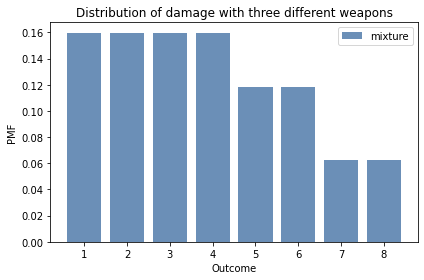

In [63]:
mix.bar(label='mixture', alpha=0.6)
decorate_dice('Distribution of damage with three different weapons')

In this section I used Pandas so that `make_mixture` is concise, efficient, and hopefully not too hard to understand.
In the exercises at the end of the chapter, you'll have a chance to practice with mixtures, and we will use `make_mixture` again in the next chapter.

## Summary

This chapter introduces the `Cdf` object, which represents the cumulative distribution function (CDF).

A `Pmf` and the corresponding `Cdf` are equivalent in the sense that they contain the same information, so you can convert from one to the other.  
The primary difference between them is performance: some operations are faster and easier with a `Pmf`; others are faster with a `Cdf`.

In this chapter we used `Cdf` objects to compute distributions of maximums and minimums; these distributions are useful for inference if we are given a maximum or minimum as data.
You will see some examples in the exercises, and in future chapters.
We also computed mixtures of distributions, which we will use in the next chapter to make predictions.

But first you might want to work on these exercises.

## Exercises

**Exercise:** When you generate a D&D character, instead of rolling dice, you can use the "standard array" of attributes, which is 15, 14, 13, 12, 10, and 8.
Do you think you are better off using the standard array or (literally) rolling the dice?

Compare the distribution of the values in the standard array to the distribution we computed for the best three out of four:

* Which distribution has higher mean?  Use the `mean` method.

* Which distribution has higher standard deviation?  Use the `std` method.

* The lowest value in the standard array is 8.  For each attribute, what is the probability of getting a value less than 8?  If you roll the dice six times, what's the probability that at least one of your attributes is less than 8?

* The highest value in the standard array is 15.  For each attribute, what is the probability of getting a value greater than 15?  If you roll the dice six times, what's the probability that at least one of your attributes is greater than 15?

To get you started, here's a `Cdf` that represents the distribution of attributes in the standard array:

In [64]:
standard = [15,14,13,12,10,8]
cdf_standard = Cdf.from_seq(standard)

We can compare it to the distribution of attributes you get by rolling four dice at adding up the best three.

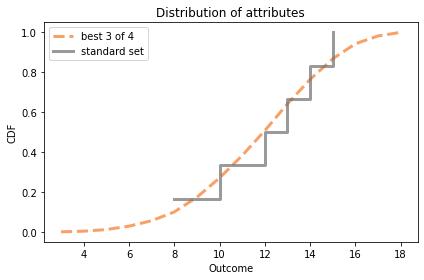

In [68]:
cdf_best3.plot(label='best 3 of 4', color='C1', ls='--')
cdf_standard.step(label='standard set', color='C7')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

I plotted `cdf_standard` as a step function to show more clearly that it contains only a few quantities.

In [66]:
# Solution goes here
print(f'평균 비교 {cdf_best3.mean()}, {cdf_standard.mean()}')
print(f'표준편차 비교 {cdf_best3.std()}, {cdf_standard.std()}')
print(cdf_min6.lt_dist(8), 1 - (1-cdf_best3.lt_dist(8))**6)
print(cdf_max6.gt_dist(15), 1 - (1-cdf_best3.gt_dist(15))**6)

평균 비교 12.2183, 12.0
표준편차 비교 2.8740294205174726, 2.3804761428476167
0.30615763900456217 0.30615763900456217
0.5648763862158948 0.5648763862158951


In [ ]:
# Solution goes here

**Exercise:** Suppose you are fighting three monsters:

* One is armed with a short sword that causes one 6-sided die of damage,

* One is armed with a battle axe that causes one 8-sided die of damage, and

* One is armed with a bastard sword that causes one 10-sided die of damage.

One of the monsters, chosen at random, attacks you and does 1 point of damage.

Which monster do you think it was?  Compute the posterior probability that each monster was the attacker.

If the same monster attacks you again, what is the probability that you suffer 6 points of damage?

Hint: Compute a posterior distribution as we have done before and pass it as one of the arguments to `make_mixture`.

In [67]:
# Solution goes here
hypos = [6, 8, 10]
prior = Pmf(1, hypos)
likelihood = 1/prior.qs
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
6,0.425532
8,0.319149
10,0.255319


In [68]:
# Solution goes here
d6 = make_die(6)
d8 = make_die(8)
d10 = make_die(10)

dice = d6, d8, d10

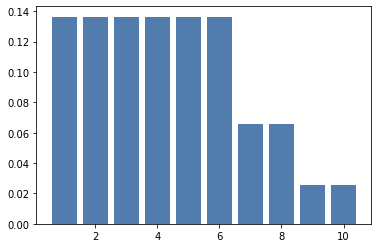

In [69]:
# Solution goes here
mix3 = make_mixture(posterior, dice)
mix3.bar()

In [70]:
# Solution goes here
mix3[6]

0.13634751773049647

**Exercise:** Henri Poincaré was a French mathematician who taught at the Sorbonne around 1900. The following anecdote about him is probably fiction, but it makes an interesting probability problem.

Supposedly Poincaré suspected that his local bakery was selling loaves of bread that were lighter than the advertised weight of 1 kg, so every day for a year he bought a loaf of bread, brought it home and weighed it. At the end of the year, he plotted the distribution of his measurements and showed that it fit a normal distribution with mean 950 g and standard deviation 50 g. He brought this evidence to the bread police, who gave the baker a warning.

For the next year, Poincaré continued to weigh his bread every day. At the end of the year, he found that the average weight was 1000 g, just as it should be, but again he complained to the bread police, and this time they fined the baker.

Why? Because the shape of the new distribution was asymmetric. Unlike the normal distribution, it was skewed to the right, which is consistent with the hypothesis that the baker was still making 950 g loaves, but deliberately giving Poincaré the heavier ones.

To see whether this anecdote is plausible, let's suppose that when the baker sees Poincaré coming, he hefts `n` loaves of bread and gives Poincaré the heaviest one.  How many loaves would the baker have to heft to make the average of the maximum 1000 g?

To get you started, I'll generate a year's worth of data from a normal distribution with the given parameters.

In [71]:
mean = 950
std = 50

np.random.seed(17)
sample = np.random.normal(mean, std, size=365)

In [72]:
# Solution goes here
cdf = Cdf.from_seq(sample)

for n in range(2, 6):
    cdf_max = cdf.max_dist(n)
    print(n, cdf_max.mean())

2 978.4666876067706
3 992.7589004318227
4 1002.0372868686195
5 1008.8226939493089


In [73]:
# Solution goes here
cdf = Cdf.from_seq(sample)

for n in range(2, 6):
    cdf_max = cdf.max_dist(n)
    print(n, cdf_max.mean())

2 978.4666876067706
3 992.7589004318227
4 1002.0372868686195
5 1008.8226939493089
